In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras import applications


ModuleNotFoundError: No module named 'tensorflow'

### Split classes into Train/Val/Test
<p>
The following code creates a new directory from Ingredients directory with classes into a train,validation and test split.
</p>
<p>
Should be run once after new classes or images are added and deleting split_data directory
</p>

In [2]:
# Define paths
dataset_dir = "Ingredients/"  # Your original dataset
output_dir = "split_data/"  # Where the split data will be stored

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create train, val, test directories
for split in ["train", "val", "test"]:
    for category in os.listdir(dataset_dir):
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Function to split and move files
def split_data(source, train_dest, val_dest, test_dest):
    for category in os.listdir(source):
        category_path = os.path.join(source, category)
        images = os.listdir(category_path)

        # Split dataset
        train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

        # Move files
        for img in train_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dest, category, img))
        for img in val_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dest, category, img))
        for img in test_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dest, category, img))

# Apply split
split_data(dataset_dir, output_dir + "train", output_dir + "val", output_dir + "test")

print("✅ Dataset split complete!")


✅ Dataset split complete!


<p>
Split data into Train/Val/Test
</p>

In [3]:
# Define paths
train_dir = "split_data/train"
val_dir = "split_data/val"
test_dir = "split_data/test"

# Load datasets
IMG_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(train_dir, 
                                        image_size=IMG_SIZE, 
                                        batch_size=BATCH_SIZE)

val_ds = image_dataset_from_directory(val_dir, 
                                      image_size=IMG_SIZE, 
                                      batch_size=BATCH_SIZE)

test_ds = image_dataset_from_directory(test_dir, 
                                       image_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE)

# Print class names
class_names = train_ds.class_names
print("Classes:", class_names)


Found 222 files belonging to 3 classes.
Found 47 files belonging to 3 classes.
Found 50 files belonging to 3 classes.
Classes: ['Butter', 'Eggs', 'PackagedBread']


## Data Augmentation

In [4]:
# Normalize pixels to [0,1]
normalization_layer = layers.Rescaling(1./255)

# Apply augmentation (flipping, rotation, zoom, etc.)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Apply to dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


## Model Architecture

In [5]:

# Build CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', kernel_initializer = "he_normal", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation = "relu", kernel_initializer = "he_normal"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

EarlyStoppingCB = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)
LearningRateCB = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 3)

adamW_optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.001, weight_decay = 0.004)
nag_optmizer = tf.keras.optimizers.SGD(learning_rate = 0.001, nesterov=True, momentum=0.9)

# Compile model
model.compile(optimizer=adamW_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Print model architecture


c:\Users\Ameya Mahankala\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [6]:
EPOCHS = 70

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=EPOCHS,
                    callbacks=[EarlyStoppingCB, LearningRateCB])

Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.3589 - loss: 6.9328 - val_accuracy: 0.3617 - val_loss: 1.4072 - learning_rate: 0.0010
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.4527 - loss: 1.1500 - val_accuracy: 0.6383 - val_loss: 0.9499 - learning_rate: 0.0010
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.5576 - loss: 0.9500 - val_accuracy: 0.6383 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5657 - loss: 0.8234 - val_accuracy: 0.6809 - val_loss: 0.7066 - learning_rate: 0.0010
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.6547 - loss: 0.7738 - val_accuracy: 0.7447 - val_loss: 0.6625 - learning_rate: 0.0010
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.6147 - loss: 0.7836 - val_accuracy: 0.7660 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7746 - loss: 0.6325 - val_accuracy: 

In [7]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7908 - loss: 0.6744 
Test Accuracy: 0.78


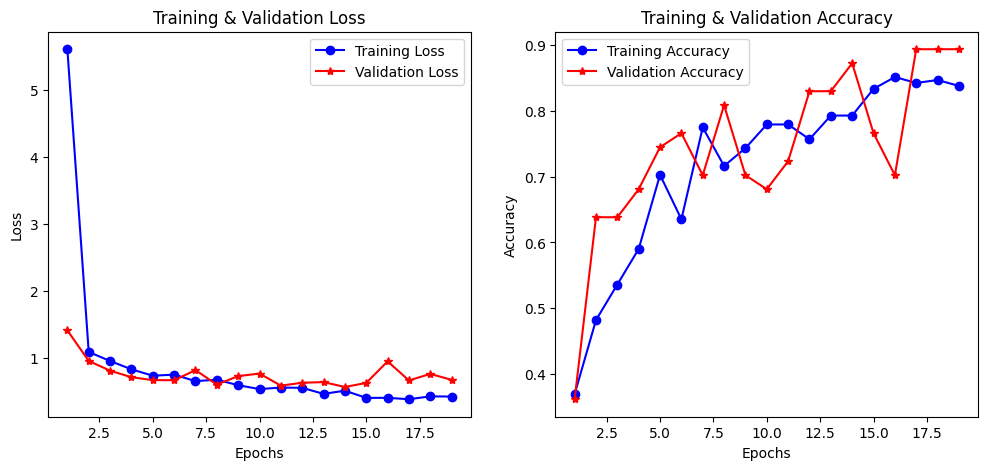

In [8]:

# Extract accuracy and loss from the history object
cnn_train_loss = history.history['loss']
cnn_val_loss = history.history['val_loss']
cnn_train_acc = history.history['accuracy']
cnn_val_acc = history.history['val_accuracy']

epochs = range(1, len(cnn_train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, cnn_val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, cnn_val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [9]:
# Load a test image
img_path = "split_data/test/PackagedBread/bread.jpg_1.jpeg"  # Change this to a real image path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict class
predictions = model.predict(img_array)
# Get predicted class and probability
predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]
predicted_probability = predictions[0][predicted_class]

print(f"Predicted class: {predicted_class_name}")
print(f"Confidence (Probability): {predicted_probability:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted class: PackagedBread
Confidence (Probability): 0.9632


# Transfer Learning

In [10]:
# Load pre-trained MobileNetV2 without the classification head
base_model = applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

# Freeze base model layers
base_model.trainable = False

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer for our classes
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Print model architecture


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
EPOCHS = 10  

tfl_history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=EPOCHS)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.6059 - loss: 0.9876 - val_accuracy: 1.0000 - val_loss: 0.0685
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9061 - loss: 0.1898 - val_accuracy: 1.0000 - val_loss: 0.0148
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9916 - loss: 0.0590 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9550 - loss: 0.1389 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9888 - loss: 0.0319 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9858 - loss: 0.0316 - val_accuracy: 1.0000 - val_loss: 6.0967e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 4.0744e-04
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - v

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0104
Test Accuracy: 1.00


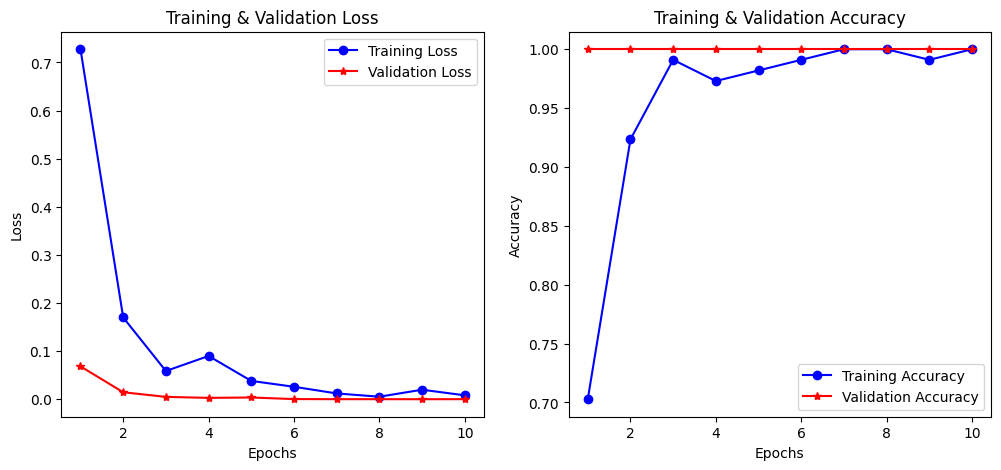

In [13]:
# Extract accuracy and loss from the history object
cnn_train_loss = tfl_history.history['loss']
cnn_val_loss = tfl_history.history['val_loss']
cnn_train_acc = tfl_history.history['accuracy']
cnn_val_acc = tfl_history.history['val_accuracy']

epochs = range(1, len(cnn_train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, cnn_train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, cnn_val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, cnn_train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, cnn_val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [14]:
# Load a test image
img_path = "split_data/test/PackagedBread/bread.jpg_1.jpeg"  # Change this to a real image path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict class
predictions = model.predict(img_array)
# Get predicted class and probability
predicted_class = np.argmax(predictions)
predicted_class_name = class_names[predicted_class]
predicted_probability = predictions[0][predicted_class]

print(f"Predicted class: {predicted_class_name}")
print(f"Confidence (Probability): {predicted_probability:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
Predicted class: PackagedBread
Confidence (Probability): 1.0000


### Save Model

In [1]:
import tensorflowjs as tfjs
from tensorflow import keras
import numpy as np

# Load the Keras model
model = keras.models.load_model('IngredientClassifier.h5')

# Convert the model to TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

print("Conversion complete. Model saved in tfjs_model/")

c:\Users\Ameya Mahankala\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [1]:
import tensorflowjs as tfjs
model= keras.models.load_model("IngredientClassifier.h5")
#tfjs.converters.save_keras_model(model, "tfjs_target_dir/")

c:\Users\Ameya Mahankala\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [22]:
import tensorflowjs as tfjs
from tensorflow import keras
model = keras.models.load_model('IngredientClassifier.h5')

# Convert and save
tfjs.converters.save_keras_model(model, 'path/to/tfjs_model')

c:\Users\Ameya Mahankala\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations